In [151]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [152]:
data = pd.read_csv('dataset.csv')
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [153]:
data['pixels'] = data['pixels'].apply(lambda x: x/255)
# Yukarıdaki adımda, pixels sütunundaki değerler normalize ediliyor. Normalize etme işlemi, piksel değerlerini 0 ile 1 arasında bir aralığa getirir.
age_dist = data['age'].value_counts() ## calculating distributions
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male', 1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

In [154]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

In [155]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

In [156]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

In [157]:
X = np.array(data['pixels'].tolist())

X = X.reshape(X.shape[0],48,48,1) ## Converting pixels from 1D to 3D
X

array([[[[0.5058824 ],
         [0.5019608 ],
         [0.5019608 ],
         ...,
         [0.4627451 ],
         [0.3882353 ],
         [0.20784314]],

        [[0.50980395],
         [0.5058824 ],
         [0.5019608 ],
         ...,
         [0.45882353],
         [0.38431373],
         [0.20392157]],

        [[0.5137255 ],
         [0.5058824 ],
         [0.50980395],
         ...,
         [0.44705883],
         [0.38039216],
         [0.19607843]],

        ...,

        [[0.4745098 ],
         [0.5411765 ],
         [0.5764706 ],
         ...,
         [0.5921569 ],
         [0.5882353 ],
         [0.5803922 ]],

        [[0.45882353],
         [0.5372549 ],
         [0.57254905],
         ...,
         [0.58431375],
         [0.5803922 ],
         [0.5803922 ]],

        [[0.4509804 ],
         [0.5294118 ],
         [0.5568628 ],
         ...,
         [0.57254905],
         [0.57254905],
         [0.57254905]]],


       [[[0.6431373 ],
         [0.2901961 ],
         [0.43

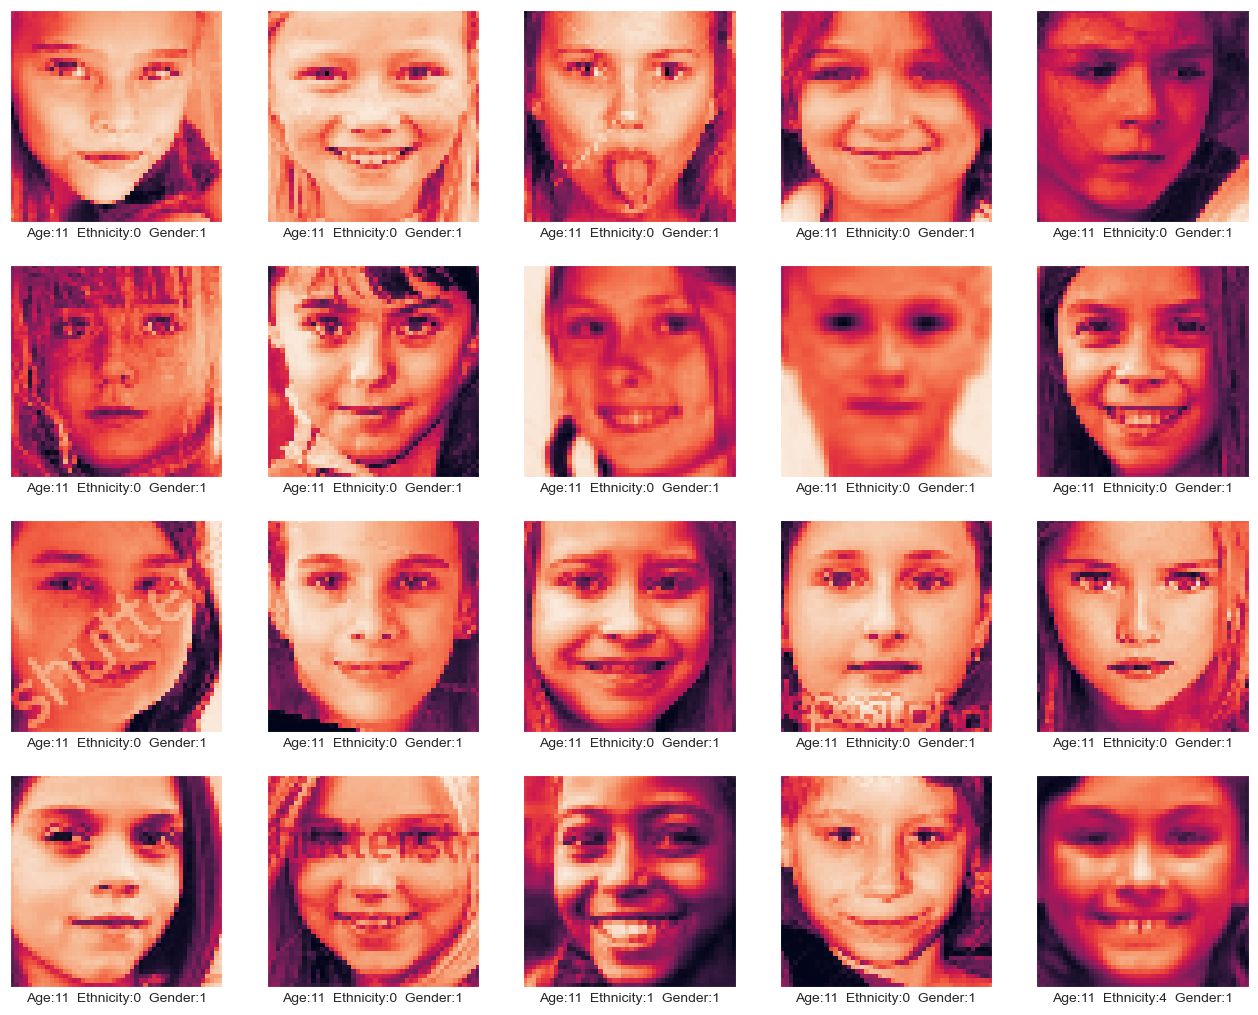

In [158]:
plt.figure(figsize=(16,16))
for i in range(1300,1320):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
        "Age:"+str(data['age'].iloc[i])+
        "  Ethnicity:"+str(data['ethnicity'].iloc[i])+
        "  Gender:"+ str(data['gender'].iloc[i])
    )
plt.show()

CNN model for gender prediction

In [159]:
y = data['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

In [160]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='sigmoid')
])

model.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


C:\Users\yasin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.

C:\Users\yasin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [161]:
 # TensorFlow ve Keras kullanarak derin öğrenme modelleri eğitimi sırasında belirli bir koşula ulaşıldığında eğitimi durdurmak için özel bir geri çağırma (callback) oluşturur.

class Callback(tf.keras.callbacks.Callback): ## Stop training when validation loss reach 0.2700
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_loss') < 0.2600:
            print("\nReached 0.2600 val_loss so cancelling training!")
            self.model.stop_training = True
            
# on_epoch_end: Bu yöntem, her epoch (eğitim döngüsü) sonunda çağrılır. epoch ve logs parametreleri alır. epoch, mevcut epoch numarasını ve logs ise eğitim ve doğrulama kayıplarını (loss) ve diğer metrikleri içerir.

callback = Callback()

model.summary()

# Callback kullanılmasının amacı modelin validation loss değeri belirli bir değere ulaştığında eğitimi durdurmaktır. Bu, overfitting önlemek ve gereksiz yere fazla epoch eğitimi yapmamak için kullanışlıdır.

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,673 (1.64 MB)

 Trainable params: 428,609 (1.64 MB)

 Non-trainable params: 64 (256.00 B)

In [162]:
history = model.fit(X_train, y_train, epochs=32, validation_split=0.12, batch_size=64, callbacks=[callback]) 

# validation_split=0.1 parametresi ile eğitim verilerinin %10'u doğrulama verileri olarak ayrılıyor. Validation verileri, modelin eğitim sırasında ne kadar iyi performans gösterdiğini kontrol etmek için kullanılır.

Epoch 1/32
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6894 - loss: 0.5830 - val_accuracy: 0.8025 - val_loss: 0.5880
Epoch 2/32
258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8191 - loss: 0.4095 - val_accuracy: 0.8456 - val_loss: 0.3957
Epoch 3/32
258/258 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.8423 - loss: 0.3562 - val_accuracy: 0.8221 - val_loss: 0.3814
Epoch 4/32
258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8583 - loss: 0.3282 - val_accuracy: 0.8528 - val_loss: 0.3180
Epoch 5/32
258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8638 - loss: 0.3026 - val_accuracy: 0.8612 - val_loss: 0.3106
Epoch 6/32
258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8738 - loss: 0.3027 - val_accuracy: 0.8545 - val_loss: 0.3079
Epoch 7/32
258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8746 - loss: 0.2903 - val_accuracy: 0.8657 - val_loss: 0.3043
Epoch 8/32
258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8806 - loss: 0.2753 - val_accu

Evaluate training history

In [163]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

loss: Modelin eğitim veri seti üzerindeki hatasını gösterir. Model her epoch'ta eğitim verileri üzerinde eğitildiğinde, her örnek için tahmin edilen değer ile gerçek değer arasındaki farkı (kayıp fonksiyonu kullanarak) hesaplar. Bu farkların ortalaması, eğitim kaybı olarak adlandırılır. Loss, modelin eğitim verilerini ne kadar iyi öğrendiğini gösterir. Eğitim kaybının düşük olması, modelin eğitim verileri üzerindeki performansının iyi olduğunu gösterir.

val_loss: Modelin doğrulama veri seti üzerindeki hatasını gösterir. Model, her epoch'ta eğitim tamamlandıktan sonra doğrulama veri seti üzerinde test edilir. Doğrulama verileri eğitim sırasında modele gösterilmediği için, modelin bu veriler üzerindeki tahminleri, modelin genelleme yeteneğini (eğitim verilerine aşırı uyum sağlamadan genel performansını) gösterir. Tahmin edilen değer ile gerçek değer arasındaki farklar hesaplanır ve ortalaması doğrulama kaybı olarak adlandırılır. Doğrulama kaybı, modelin eğitim verileri dışında yeni veriler üzerindeki performansını gösterir. Düşük doğrulama kaybı, modelin iyi genelleme yaptığını ve yeni verilerde de iyi performans göstereceğini belirtir.

loss düşük ama val_loss yüksekse, model eğitim verilerine overfit olabilir. Bu durumda model, eğitim verilerini çok iyi öğrenmiş fakat yeni verilere genelleyemiyor demektir.

Eğer hem loss hem de val_loss yüksekse, model verileri yeterince iyi öğrenememiştir yani underfitting olmuştur. Bu durumda modelin kapasitesini artırmak, daha fazla eğitim verisi kullanmak veya eğitim süresini uzatmak gerekebilir.,

Eğer hem loss hem de val_loss düşükse ve birbirine yakınsa, model hem eğitim verilerini iyi öğrenmiş hem de yeni verilere iyi genelleyebiliyor demektir.


Model sonuçlarında loss ve val_loss birbirine çok yakın seyrediyor. Bu, modelin eğitim veri setine çok fazla aşırı uyum sağlamadığını yani overfit olmadığını ve genelleme yeteneğinin iyi olduğunu gösterir.


In [164]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.2565915882587433
Test Accuracy: 0.8923478722572327


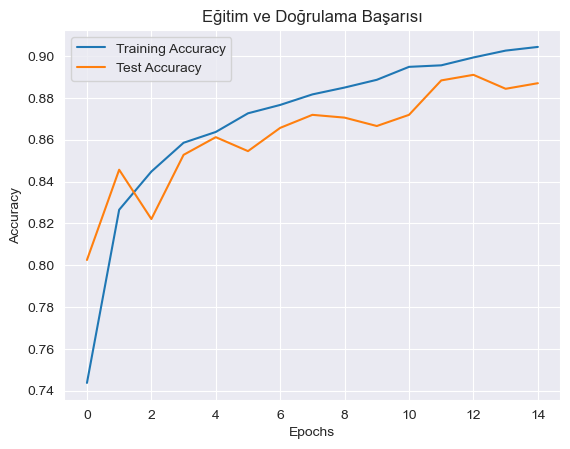

In [165]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Eğitim ve Doğrulama Başarısı')
plt.show()


Eğitim Başarısı (Training Accuracy):

Eğitim başarısı, modelin eğitim veri seti üzerindeki doğruluk oranını ifade eder.
Doğruluk, doğru tahmin edilen örneklerin toplam örnek sayısına oranını ifade eder. Yani, (doğru tahmin sayısı) / (toplam örnek sayısı) formülü ile hesaplanır.
Eğitim başarısı, modelin eğitim veri setinde ne kadar iyi performans gösterdiğini ölçer. Ancak, bu değer modelin genelleme yeteneği hakkında tam bir bilgi vermez.
Test Başarısı (Test Accuracy):

Test başarısı, modelin görmemiş olduğu bir test veri seti üzerindeki doğruluk oranını ifade eder.
Eğitim sırasında, model her epoch sonunda test seti üzerinde tahminlerde bulunur ve bu set üzerinde doğruluk oranını elde eder.
Test başarısı, modelin genelleme yeteneğini ölçer. Yani, eğitim veri setine aşırı öğrenme yapılmış mı ve yeni veriler üzerinde de iyi performans gösterebiliyor mu sorularına cevap arar.

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


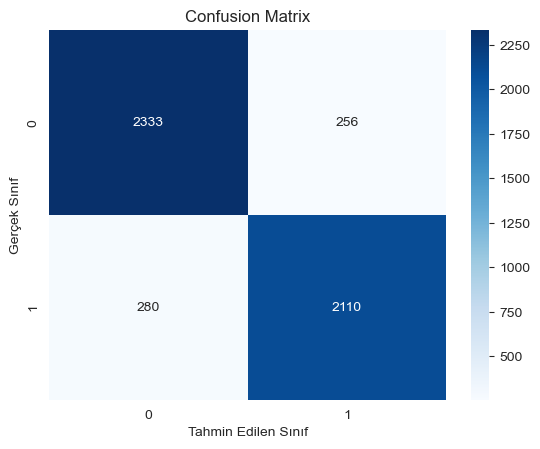

In [166]:
y_pred = model.predict(X_test)

y_pred_classes = np.round(y_pred)

cm = confusion_matrix(y_test, y_pred_classes)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.show()

CNN Model for Ethnicity Prediction

In [167]:
y = data['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [168]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.3),
    L.Dense(5)
])

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\yasin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.

C:\Users\yasin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [169]:
class Callback(tf.keras.callbacks.Callback): # Stop training when validation accuracy reach 790%
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy')>0.790:
            print("\nReached 790% val_accuracy so cancelling training!")
            self.model.stop_training = True
        
callback = Callback()

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,805 (1.64 MB)

 Trainable params: 428,805 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [170]:
history = model.fit(
    X_train, y_train, epochs=32, validation_split=0.12, batch_size=64, callbacks=[callback]
)

Epoch 1/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4480 - loss: 1.3910 - val_accuracy: 0.6366 - val_loss: 0.9519
Epoch 2/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6373 - loss: 0.9953 - val_accuracy: 0.7170 - val_loss: 0.8404
Epoch 3/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6929 - loss: 0.8755 - val_accuracy: 0.7478 - val_loss: 0.7348
Epoch 4/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7288 - loss: 0.7933 - val_accuracy: 0.7685 - val_loss: 0.6856
Epoch 5/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7410 - loss: 0.7412 - val_accuracy: 0.7632 - val_loss: 0.6796
Epoch 6/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7568 - loss: 0.7065 - val_accuracy: 0.7707 - val_loss: 0.6518
Epoch 7/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7674 - loss: 0.6642 - val_accuracy: 0.7869 - val_loss: 0.6327
Epoch 8/32
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7822 - loss: 0.6267 - val_accu

In [171]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [172]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.6405822038650513
Test Accuracy: 0.7821134924888611


CNN Model for Age prediction

In [174]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42)

In [175]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(128, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='relu')
])

sgd = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

C:\Users\yasin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.

C:\Users\yasin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [177]:
# Stop training when validation loss reach 110
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_loss')<110:
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = Callback()

model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,001 (875.00 KB)

 Trainable params: 223,937 (874.75 KB)

 Non-trainable params: 64 (256.00 B)

In [178]:
history = model.fit(
    X_train, y_train, epochs=32, validation_split=0.11, batch_size=64, callbacks=[callback]
)

Epoch 1/32
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 494.3842 - mae: 16.9039 - val_loss: 1145.5786 - val_mae: 28.2065
Epoch 2/32
251/251 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 236.5832 - mae: 11.6738 - val_loss: 445.6337 - val_mae: 16.4619
Epoch 3/32
251/251 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 178.0491 - mae: 9.9053 - val_loss: 316.4508 - val_mae: 13.5650
Epoch 4/32
251/251 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 167.2277 - mae: 9.6597 - val_loss: 168.6277 - val_mae: 10.4647
Epoch 5/32
251/251 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 157.0715 - mae: 9.2461 - val_loss: 188.1660 - val_mae: 9.8842
Epoch 6/32
249/251 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 140.8246 - mae: 8.7666
Reached 110 val_loss so cancelling training!
251/251 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 140.8081 - mae: 8.7660 - val_loss: 107.8187 - val_mae: 7.8929


In [ ]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [ ]:
mse, mae = model.evaluate(X_test,y_test,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))